In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from time import time
warnings.filterwarnings('ignore')

Zadanie 1 - badanie klasyfikatoróœ

1.

In [2]:
X,y = make_classification(n_samples=1000, n_classes=2, n_clusters_per_class=2, n_features=2, n_informative=2, n_redundant=0, random_state=535)
X.shape

(1000, 2)

2.

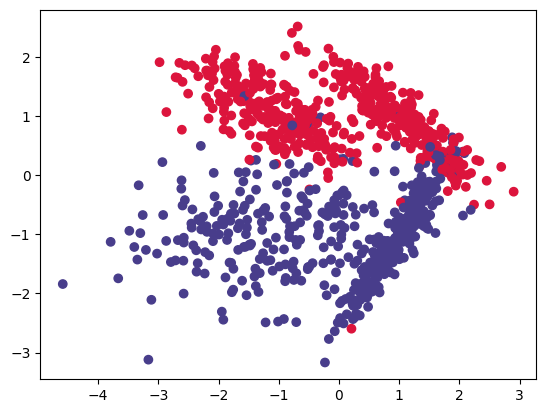

In [3]:
colormap = np.array(['darkslateblue', 'crimson'])
plt.scatter(X[:, 0], X[:, 1], c=colormap[y]);

3.

In [4]:
classifiers = [
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier()
]

In [5]:
df = pd.DataFrame(columns=["classifier", "accuracy_score", "recall_score", "precision_score",
                           "F1_score", "roc_auc", "train_time", "test_time"])

In [6]:
y_test_list = []
y_pred_proba_list = []
auc_list = []

# do krzywej dyskryminacyjnej
X_test_list = []
x_ = np.linspace(np.amin(X[:, 0]), np.amax(X[:, 0]))
y_ = np.linspace(np.amin(X[:, 1]), np.amax(X[:, 1]))
xv, yv = np.meshgrid(x_, y_)
mesh_flat = np.vstack((xv.ravel(), yv.ravel())).T
Z_list = []

for clf in classifiers:

    accuracy_list = []
    recall_list = []
    precision_list = []
    F1_list = []
    roc_auc_list = []
    test_time_list = []
    train_time_list = []

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        start_time = time()
        clf.fit(X_train, y_train)
        train_time_list.append(time() - start_time)

        start_time = time()
        y_pred = clf.predict(X_test)
        test_time_list.append(time() - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        F1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        accuracy_list.append(accuracy)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append(F1)
        roc_auc_list.append(roc_auc)

        if i == 99:
            # do ROC
            y_test_list.append(y_test)
            y_pred_proba = clf.predict_proba(X_test)[:, 1]
            y_pred_proba_list.append(y_pred_proba)
            auc_list.append(roc_auc)

            # do krzywej dyskryminacyjnej
            X_test_list.append(X_test)
            Z = clf.predict(mesh_flat)
            Z = Z.reshape(xv.shape)
            Z_list.append(Z)


    classifier = clf.__class__.__name__
    accuracy = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    F1 = np.mean(F1_list)
    train_time = np.mean(train_time_list)
    test_time = np.mean(test_time_list)
    roc_auc = np.mean(roc_auc_list)
    classifier_name = clf.__class__.__name__
    
    df = df.append({
        'classifier': classifier_name,
        'accuracy_score': accuracy,
        'recall_score': recall,
        'precision_score': precision,
        'F1_score': F1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'test_time': test_time
    }, ignore_index=True)


In [7]:
df = df.set_index('classifier')
df

,accuracy_score,recall_score,precision_score,F1_score,roc_auc,train_time,test_time
classifier,,,,,,,
GaussianNB,0.932633,0.946611,0.921615,0.933713,0.932609,0.000492,0.000128
QuadraticDiscriminantAnalysis,0.941900,0.966644,0.921275,0.943201,0.942045,0.000517,0.000125
KNeighborsClassifier,0.948333,0.964964,0.934230,0.949160,0.948336,0.000382,0.004329
SVC,0.948467,0.986679,0.917492,0.950710,0.948143,0.009527,0.000953
DecisionTreeClassifier,0.934600,0.933516,0.935516,0.934218,0.934569,0.000813,0.000077


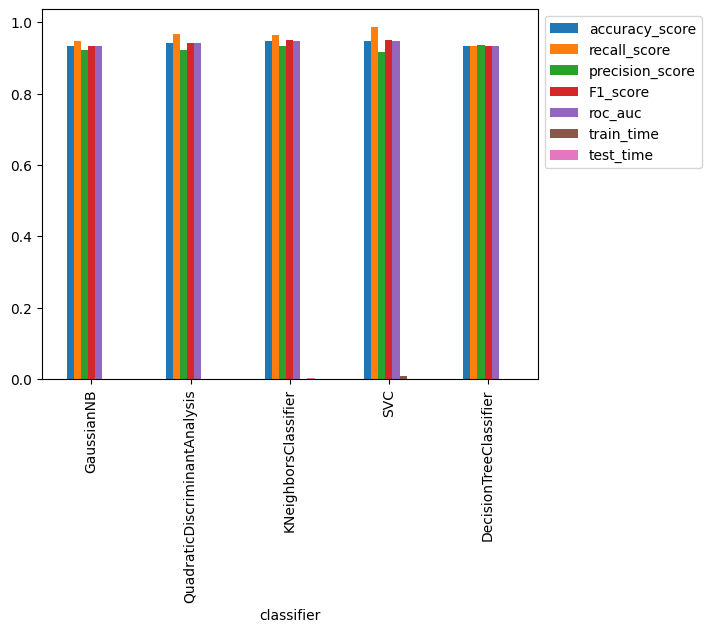

In [8]:
df.plot(kind='bar', rot=90).legend(bbox_to_anchor=(1, 1));


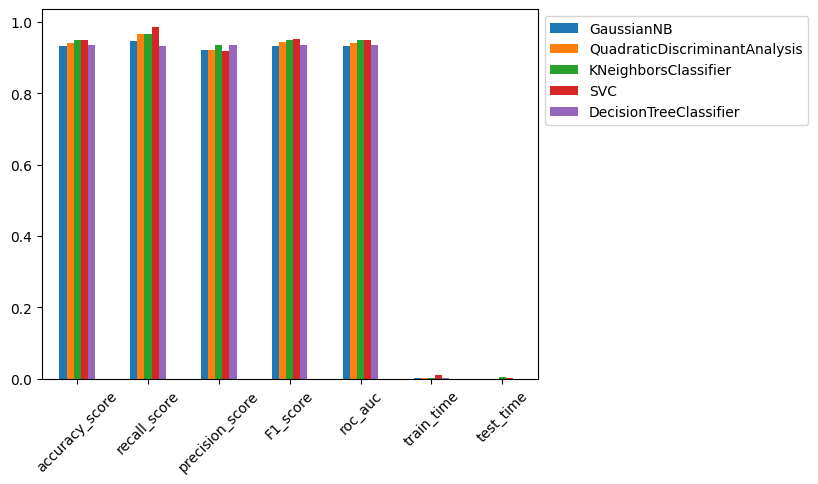

In [9]:
df = df.T
df.plot(kind='bar', rot=45).legend(bbox_to_anchor=(1, 1));


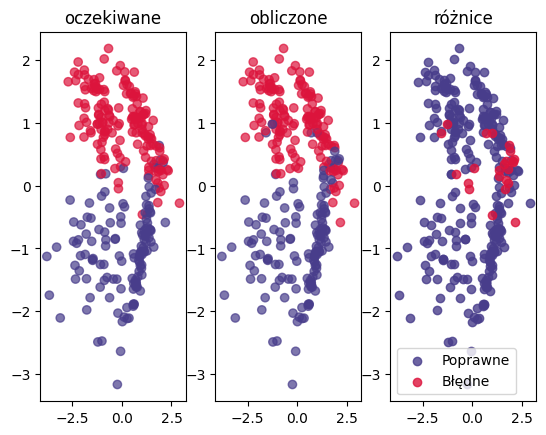

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.scatter(X_test[:, 0], X_test[:, 1], c=colormap[y_test], alpha=0.7)
ax2.scatter(X_test[:, 0], X_test[:, 1], c=colormap[y_pred], alpha=0.7)

correct = X_test[y_test == y_pred]
incorrect = X_test[y_test != y_pred]

ax3.scatter(correct[:, 0], correct[:, 1], c=colormap[0], alpha=0.8, label="Poprawne")
ax3.scatter(incorrect[:, 0], incorrect[:, 1], c=colormap[1], alpha=0.8, label="Błędne")
ax3.legend()

ax1.set_title('oczekiwane')
ax2.set_title('obliczone')
ax3.set_title('różnice');

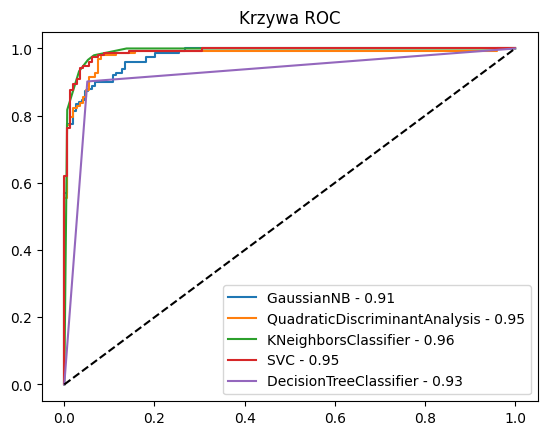

In [11]:
for i in range(len(classifiers)):
    y_test = y_test_list[i]
    y_pred_proba = y_pred_proba_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr, label=f"{classifiers[i].__class__.__name__} - {round(auc_list[i], 2)}")

plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.title("Krzywa ROC")
plt.legend();

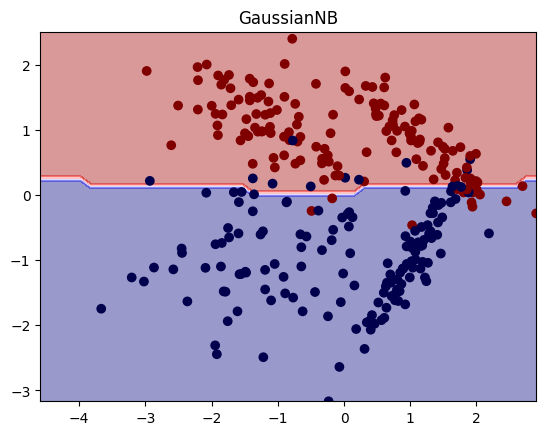

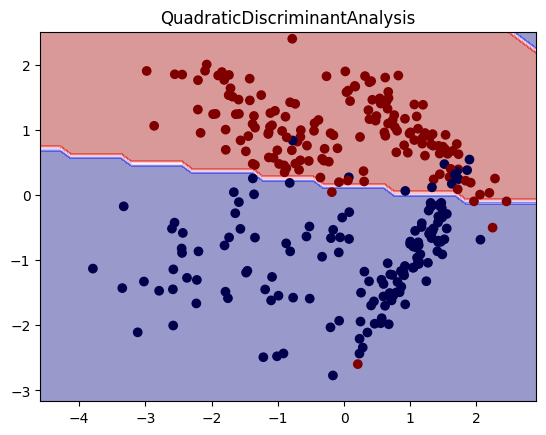

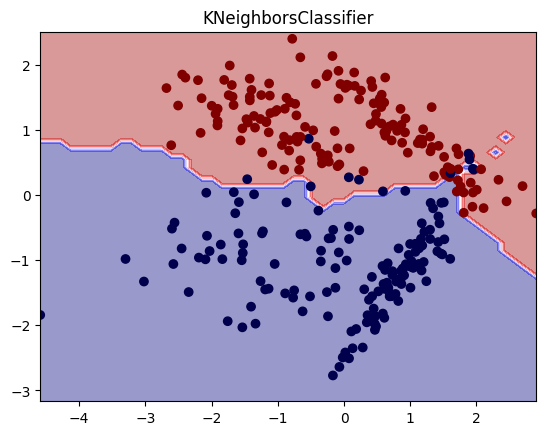

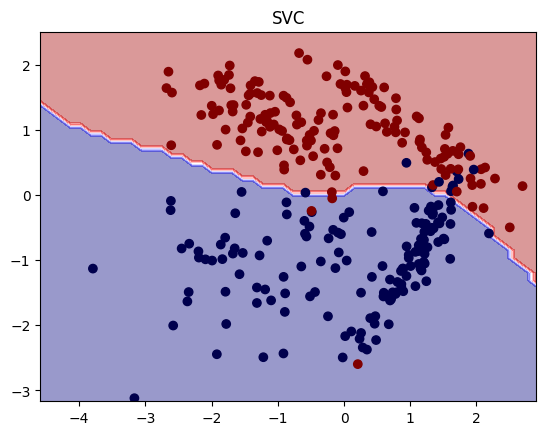

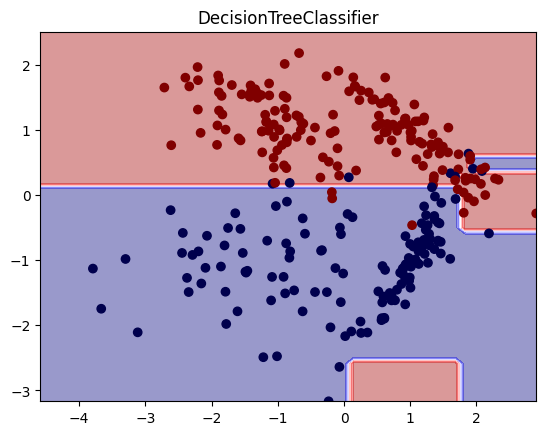

In [12]:
for i in range(len(classifiers)):
    plt.contourf(xv, yv, Z_list[i], cmap='seismic', alpha=.4)
    # plt.contour(xv, yv, Z_list[i])
    plt.scatter(X_test_list[i][:, 0], X_test_list[i][:, 1], cmap='seismic', c=y_test_list[i])
    plt.title(classifiers[i].__class__.__name__)
    plt.show()

# plt.contour(xv, yv, Z_list[4])
# plt.scatter(X_test_list[4][:, 0], X_test_list[4][:, 1], c=colormap[y_test_list[4]])


Zadanie 2

1.

In [13]:
X,y = make_classification(n_samples=300, n_classes=2, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=9908)

2, 3.

In [14]:
# tylko część parametrów, żeby nie trwało to tak długo
SVC_parameters = {
        "C": [1e-3, 1e-1, 1e1, 1e3],
        "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
        "degree": [2, 3, 4],
        "gamma": [1e-3, 1e-2, 1e-1],
        "coef0": [0.0, 0.4, 0.8],
        "shrinking": [True, False],
        "probability": [True, False],
        # "tol": [1e-3, 1e-4, 1e-5],
        # "verbose": [True, False],
        # "max_iter": [5, 10, 30]
}


        # "C": [1e-3, 1e-1, 1e1, 1e3],
        # "kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        # "degree": [2, 3, 4, 5, 6],
        # "gamma": [1e-3, 1e-2, 1e-1],
        # "coef0": [0.2, 0.4, 0.6],
        # "shrinking": [True, False],
        # "probability": [True, False],
        # "tol": [1e-4, 1e-4, 1e-2],
        # "verbose": [True, False],
        # "max_iter": [500, 1000, 1500],
        # "decision_function_shape": ['ovo', 'ovr'],
        # "break_ties": [True, False]

4.

In [15]:
grid_search = GridSearchCV(SVC(), SVC_parameters, scoring=accuracy_score)
grid_search.fit(X, y);

5.

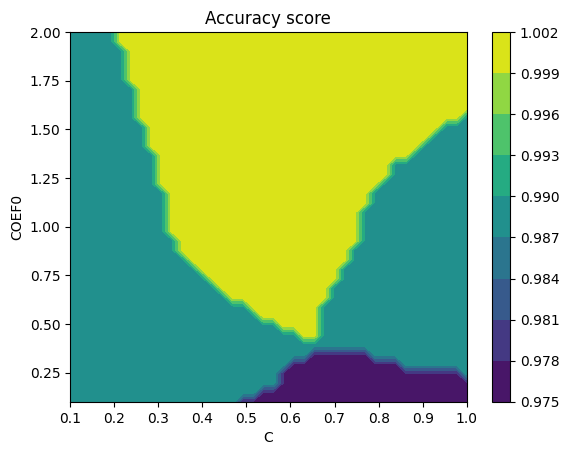

In [16]:
b = list(grid_search.best_params_)[:2]

C = np.linspace(0.1, 1, 40)
COEF = np.linspace(0.1, 2, 40)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

scores = np.empty((len(C), len(COEF)))

for i, _c in enumerate(C):
    for j, _coef in enumerate(COEF):
        clf = SVC(C=_c, gamma=_coef)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)

        scores[i, j] = accuracy_score(y_test, y_pred)

plt.contourf(C, COEF, scores)
plt.title("Accuracy score")
plt.xlabel('C')
plt.ylabel('COEF0')
plt.colorbar();

6.

In [26]:
accuracy_scores = []
recall_scores = []
precision_scores = []
F1_scores = []
roc_auc_scores = []
test_times = []
train_times = []

clf = SVC(C=0.75, coef0=0.5)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    start_time = time()
    clf.fit(X_train, y_train)
    train_times.append(time() - start_time)

    start_time = time()
    y_pred = clf.predict(X_test)
    test_times.append(time() - start_time)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)


    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    F1_scores.append(F1)
    roc_auc_scores.append(roc_auc)

    if i == 99:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)


8.

In [27]:
data = { 
        "accuracy_score": precision_scores, 
        "recall_score": recall_scores, 
        "precision_score": precision_scores,
        "F1_score": F1_scores, 
        "roc_auc": roc_auc_scores, 
        "train_time": train_times, 
        "test_time": test_times}

df = pd.DataFrame(data)
df.mean()

accuracy_score     0.986813
recall_score       1.000000
precision_score    0.986813
F1_score           0.993303
roc_auc            0.993364
train_time         0.000577
test_time          0.000144
dtype: float64

9.

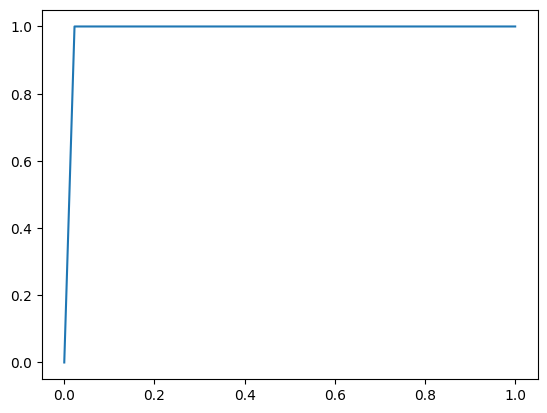

In [28]:
plt.plot(fpr, tpr)